In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import pickle
from scipy.signal import convolve
import matplotlib.image as image
import sys
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [2]:
# load spatial and temporal profile

sys.path.insert(1, '/Users/simoneebert/Documents/Repositories/motion_anticipation_network/model')

from utils import  DOG
from stimuli import stim_moving_object_for_2D_net


In [3]:
# load parameter 
net_name = f'reciprocal_ff_fitted_cell_431'
filepath = f'/Users/simoneebert/Documents/Simulations/motion_anticipation_network/Loops/{net_name}/wBA/wBA_0.0/smooth_0.14'

with open(f'{filepath}/params', 'rb') as handle:
    params = pickle.load(handle)

    

In [4]:

def bar(t, xc, b = 0.160, v = 1):

    if xc >=-b+v*t and xc <=b+v*t :
        return 1
    else: 
        return 0

In [5]:
# create profiles
stimulus_maker = stim_moving_object_for_2D_net(params,
                                                    filepath = filepath)



ftime = np.arange(0,1,params['dt'])

tkern = stimulus_maker.filter_biphasic_norm()


params['SF'] = 1.
stimulus_maker = stim_moving_object_for_2D_net(params,
                                                    filepath = filepath)

tkern_bif= stimulus_maker.filter_biphasic_norm()




spacing = params['spacing']
nb_cells = params['nb_cells']
sig_c = params['rf_BC']/6/spacing
sig_s =  params['rf_BC_s']/6/spacing
w = params['w_BC']
x = np.arange(nb_cells)*spacing
skern = DOG(x,int(nb_cells/2)*spacing, sig_c*spacing,sig_s*spacing,w)

# 2D 

def spatial_kernel(stimulus,sig_c,sig_s,w=0):

    out_c = gaussian_filter(stimulus, sig_c)
    out_s = gaussian_filter(stimulus, sig_s)
    out_total = out_c - w*out_s
        
    return out_total


In [9]:
data = {}
cell = 150
speeds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

# nets_list = ['Reciporcal_fitted/wBA/wBA_31.0',
#              'Reciporcal_fitted/noGCGainControl/wBA/wBA_31.0',
#              'Reciporcal_fitted_linear/wBA/wBA_31.0',
#              'Reciporcal_fitted_linear/noGCGainControl/wBA/wBA_31.0',
#              'Reciporcal_mono_linear/wBA/wBA_31.0',
#              'Reciporcal_mono_linear/noGCGainControl/wBA/wBA_31.0',
#              'Reciporcal_fitted_linear/noGCGainControl/wBA/wBA_0.0',
#              'Reciporcal_mono_linear/noGCGainControl/wBA/wBA_0.0',]


nets_list = ['Reciporcal_fitted/noGCGainControl/wBA/wBA_31.0',
             'Reciporcal_fitted_linear/noGCGainControl/wBA/wBA_31.0',
             'Reciporcal_mono_linear/noGCGainControl/wBA/wBA_31.0',
             'Reciporcal_fitted_linear/noGCGainControl/wBA/wBA_0.0',
             'Reciporcal_mono_linear/noGCGainControl/wBA/wBA_0.0',
             'Reciporcal_fitted/noGCGainControl/wBA/wBA_0.0',]


nets_list = ['Reciporcal_mono_linear_plastic_opt/noGCGainControl/fixed/wBA/wBA_0.0',
             'Reciporcal_mono_linear_plastic_opt/noGCGainControl/fixed/wBA/wBA_46.0' ]


# nets_list = ['Loops/fb_thesis_linear/wBA/wBA_0',
#              'Loops/fb_thesis_linear/wBA/wBA_46.0' ]

nets_list = ['Loops/ff_thesis_linear/wGA/wGA_0.0',
             'Loops/ff_thesis_linear/wGA/wGA_-0.001' ]


# nets_list = ['Loops/ff_thesis_linear_low/wBA/wBA_0.0',
#              'Loops/ff_thesis_linear_low/wBA/wBA_46.0' ]





for net in nets_list:
    
    data[net] = {}

    bars = []
    tps_rf_GC_mid = []
    times = []

    Fs = []
    RBs = []
    RAs = []
    RGs = []
    VGs = []

    peaks_RG = []
    peaks_RB = []
    peaks_drive = []

    amps_RB = []
    amps_RA = []
    amps_RG = []
    amps_drive = []

    ants_RB_drive = []
    ants_RB_bar = []

    ants_RG_drive = []
    ants_RG_bar = []
    ants_drive = []

    for s in speeds: 
        fp = f'/Users/simoneebert/Documents/Simulations/motion_anticipation_network/{net}/smooth_{s}'
        with open(f'{fp}/out', 'rb') as handle:
            out = pickle.load(handle)    
            
        with open(f'{fp}/params', 'rb') as handle:
            paramsi = pickle.load(handle)
            
        duration = paramsi['duration']
        dt = paramsi['dt']
        time = np.arange(0,duration,dt) #- (paramsi['spacing']*cell)/paramsi['speed']#*1000#+45
        pos_cell = paramsi['pos_rf_GC_mid'][cell]
        barr = [bar(t,pos_cell, v = s) for t in time]
        tp_bar = paramsi['tps_rf_GC_mid'][cell]

        peak_RB = time[np.argmax(out['RB'][50,:])]
        peak_RG = time[np.argmax(out['RG'][:])]
        peak_drive = time[np.argmax(out['F'][:])]

        amp_RB = np.max(out['RB'][50,:])
        amp_RA = np.max(out['RA'][50,:])
        amp_RG = np.max(out['RG'][:])
        amp_drive = np.max(out['F'][:])

        


        # RAM
        ant_RB_drive =  peak_drive - peak_RB
        ant_RB_bar  =  tp_bar - peak_RB

        ant_RG_drive =  peak_drive - peak_RG
        ant_RG_bar =  tp_bar - peak_RG
    
        ant_drive =  tp_bar - peak_drive

        bars.append(barr)
        tps_rf_GC_mid.append(tp_bar)
        times.append(time)

        Fs.append(out['F'])
        RBs.append(out['RB'][50,:])
        RAs.append(out['RA'][50,:])
        VGs.append(out['VG'])
        RGs.append(out['RG'])

        peaks_RB.append(peak_RB)
        peaks_RG.append(peak_RG)
        peaks_drive.append(peak_drive)

        amps_RB.append(amp_RB)
        amps_RA.append(amp_RA)
        amps_RG.append(amp_RG)
        amps_drive.append(amp_drive)

        ants_RB_drive.append(ant_RB_drive)
        ants_RB_bar.append(ant_RB_bar)
        
        ants_RG_drive.append(ant_RG_drive)
        ants_RG_bar.append(ant_RG_bar)
        ants_drive.append(ant_drive)


    
    data[net]['peaks']={}
    data[net]['peaks']['RB'] = np.asarray(peaks_RB)
    data[net]['peaks']['RG'] = np.asarray(peaks_RG)
    data[net]['peaks']['drive'] =np.asarray( peaks_drive)  

    data[net]['amps']={}
    data[net]['amps']['RB'] = np.asarray(amps_RB)
    data[net]['amps']['RA'] = np.asarray(amps_RA)
    data[net]['amps']['RG'] = np.asarray(amps_RG)
    data[net]['amps']['VG'] = np.asarray(amps_RG)
    data[net]['amps']['drive'] =np.asarray( amps_drive)

    data[net]['ants'] ={}
    data[net]['ants']['RB_drive'] =np.asarray(ants_RB_drive)
    data[net]['ants']['RB_bar'] =np.asarray(ants_RB_bar)
    data[net]['ants']['RG_drive'] =np.asarray(ants_RG_drive)
    data[net]['ants']['RG_bar'] =np.asarray(ants_RG_bar)
    data[net]['ants']['drive'] =np.asarray(ants_drive)
    
    data[net]['RB'] = RBs
    data[net]['RA'] = RAs
    data[net]['RG'] = RGs
    data[net]['VG'] = VGs
    data[net]['F'] = Fs


    data['bars'] = bars
    data['tps_rf_mid'] = np.asarray(tps_rf_GC_mid)
    data['times'] = times


FileNotFoundError: [Errno 2] No such file or directory: '/Users/simoneebert/Documents/Simulations/motion_anticipation_network/Loops/ff_thesis_linear/wGA/wGA_0.0/smooth_0.1/out'

In [7]:
net = nets_list[1]
net_pool = nets_list[0]

In [26]:
%matplotlib inline

# schematic filter

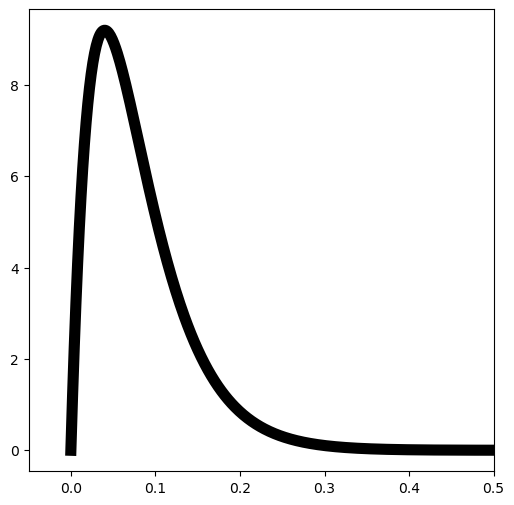

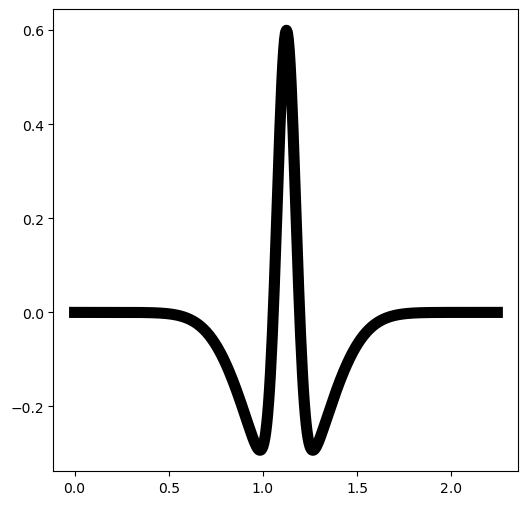

In [27]:
# plot spatial and temporal profile

plt.figure(figsize = (6,6))
plt.plot(ftime,tkern, color = 'k', linewidth = 8)
plt.xlim(-.05,0.5)




plt.figure(figsize = (6,6))
plt.plot(x,skern, color = 'k', linewidth = 8)


# filter plot for intro

In [28]:
fontsize_legend = 20
fontsize_labels = 25
fontsize_panellabel = 30
fontsize_ticks = 20
lw = 4
ms = 60

figsize_ratio = 3

figsize = (16,8)
image_format = "png"
dpi = 300

panellabel_position = [-0.05, .8]


In [29]:



def biphasic_alpha(t,tauOPL,tauOPL2,SF):
    
    kern =  (t/tauOPL**2) * np.exp(-t/tauOPL) * np.heaviside(t,1) -  SF* (t/tauOPL2**2) * np.exp(-t/tauOPL2) * np.heaviside(t,1) 
    # kern = (t/tauOPL) * np.exp(-t/tauOPL) * np.heaviside(t,1) -  SF* (t/tauOPL2) * np.exp(-t/tauOPL2) * np.heaviside(t,1) 
    # kern = kern/(np.sum(kern)*0.001)
    #calculate integral
    return  kern


tauOPLmono = 0.04
tauOPL = 0.08
tauOPL2 = 0.0876
SF = 1.

ftime = np.arange(0,1,0.001)
filter_mono = biphasic_alpha(ftime,tauOPLmono,1,0)
filter_mono = filter_mono/filter_mono.max()
filter_bi = biphasic_alpha(ftime,tauOPL,tauOPL2,SF)
filter_bi = filter_bi/filter_bi.max()


xspace = np.arange(30,70,1)




def gaussian_2D(x,sigma,pos):
    
    x,y = np.meshgrid(x,x)
    
    return np.exp(-((x-pos)**2 + (y-pos)**2)/(2*sigma**2))/(2*np.pi*sigma**2)

def DOG_2D(x,sigma_center,surround,pos):
    
    x,y = np.meshgrid(x,x)
    
    return np.exp(-((x-pos)**2 + (y-pos)**2)/(2*sigma_center**2))/(2*np.pi*sigma_center**2) - np.exp(-((x-pos)**2 + (y-pos)**2)/(2*sigma_surround**2))/(2*np.pi*sigma_surround**2)



# params 
sigma_center = 2.5
sigma_surround = 7.5
pos = 50


out_c_manual = gaussian_2D(xspace,sigma_center, pos)
out_s_manual = gaussian_2D(xspace,sigma_surround, pos)
out_total_manual = out_c_manual - 3*out_s_manual




Text(0.5, 0.5, 'y')

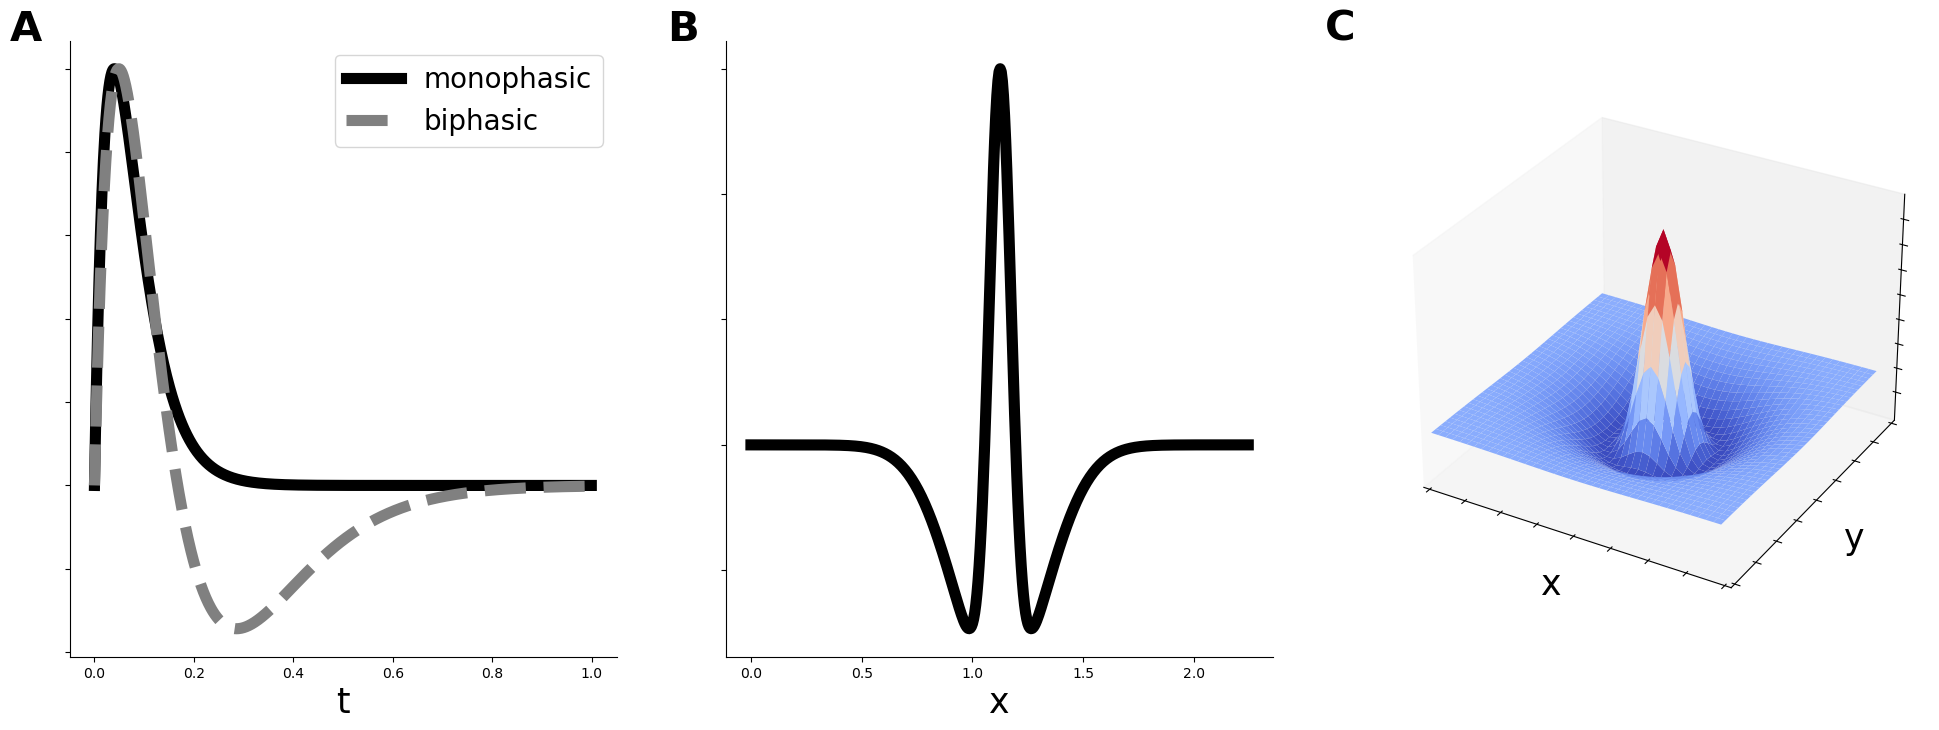

In [30]:
# plot spatial and temporal profile
x = np.arange(nb_cells)*spacing


fig= plt.figure(figsize = (24,8))


ax = fig.add_subplot(131)

ax.plot(ftime,filter_mono, color = 'k', linewidth = 8, label = 'monophasic')
ax.plot(ftime,filter_bi, color = 'grey', linewidth = 8, label = 'biphasic', linestyle = '--')
plt.xlim(-.05,1.05)
ax.set_xlabel('t', fontsize = fontsize_labels)
#ax.set_ylabel('stimulus intensity', fontsize = fontsize_labels)
ax.set_yticklabels([])
ax.spines[['right', 'top']].set_visible(False)

ax.legend(fontsize = fontsize_legend)

ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "A", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')





ax = fig.add_subplot(132)
ax.plot(x,skern, color = 'k', linewidth = 8)
ax.set_xlabel('x', fontsize = fontsize_labels)
ax.set_yticklabels([])
ax.spines[['right', 'top']].set_visible(False)

ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "B", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')



fig.text(panellabel_position[0]+1.2,panellabel_position[1]+0.25, "C", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')

ax = fig.add_subplot(133, projection='3d')

x,y = np.meshgrid(xspace,xspace)

ax.plot_surface(x,y,out_total_manual, cmap = 'coolwarm')
#ax.plot_wireframe(x,y,z)


# remove axis 
ax.set_xlim(30,70)
ax.set_ylim(30,70)


ax.grid(False)


ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlabel('x', fontsize = fontsize_labels)
ax.set_ylabel('y', fontsize = fontsize_labels)
#ax.set_zlabel('z', fontsize = fontsize_labels)

# ax.xaxis._axinfo['juggled'] = (0,0,0)
# ax.yaxis._axinfo['juggled'] = (1,1,1)
# ax.zaxis._axinfo['juggled'] = (2,2,2)



# ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "C", transform=ax.transAxes,
#           fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')





# Figure Parameter

In [31]:
circuit_scheme = image.imread('../circuit_scheme_RAM.png')


In [32]:
%matplotlib inline

<>:113: SyntaxWarning: invalid escape sequence '\m'
<>:113: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mz/v_y_dj556cs59qdf5qbn5tbc0000gn/T/ipykernel_2499/3637683845.py:113: SyntaxWarning: invalid escape sequence '\m'
  cax=cbar_ax, orientation='horizontal', label='position [$\mu m$]')


[-19.499999999999996, -18.999999999999993, -18.499999999999993, -17.999999999999993, -17.499999999999993, -17.000000000000004, -16.500000000000004, -16.000000000000004, -15.500000000000004, -15.000000000000002, -14.500000000000002, -14.000000000000002, -13.5, -13.0, -12.5, -12.0, -11.5, -10.999999999999998, -10.499999999999998, -9.999999999999998, -9.499999999999996, -8.999999999999996, -8.499999999999996, -7.9999999999999964, -7.499999999999996, -6.999999999999995, -6.499999999999995, -5.999999999999995, -5.499999999999994, -4.999999999999993, -4.5000000000000036, -4.0000000000000036, -3.500000000000003, -3.0000000000000027, -2.500000000000002, -2.0000000000000018, -1.5000000000000013, -1.0000000000000009, -0.5000000000000004, 0.0, 0.5000000000000004, 1.0000000000000009, 1.5000000000000013, 2.0000000000000018, 2.500000000000002, 3.0000000000000027, 3.500000000000003, 4.0000000000000036, 4.5000000000000036, 5.000000000000004, 5.500000000000005, 6.000000000000005, 6.500000000000005, 7.0

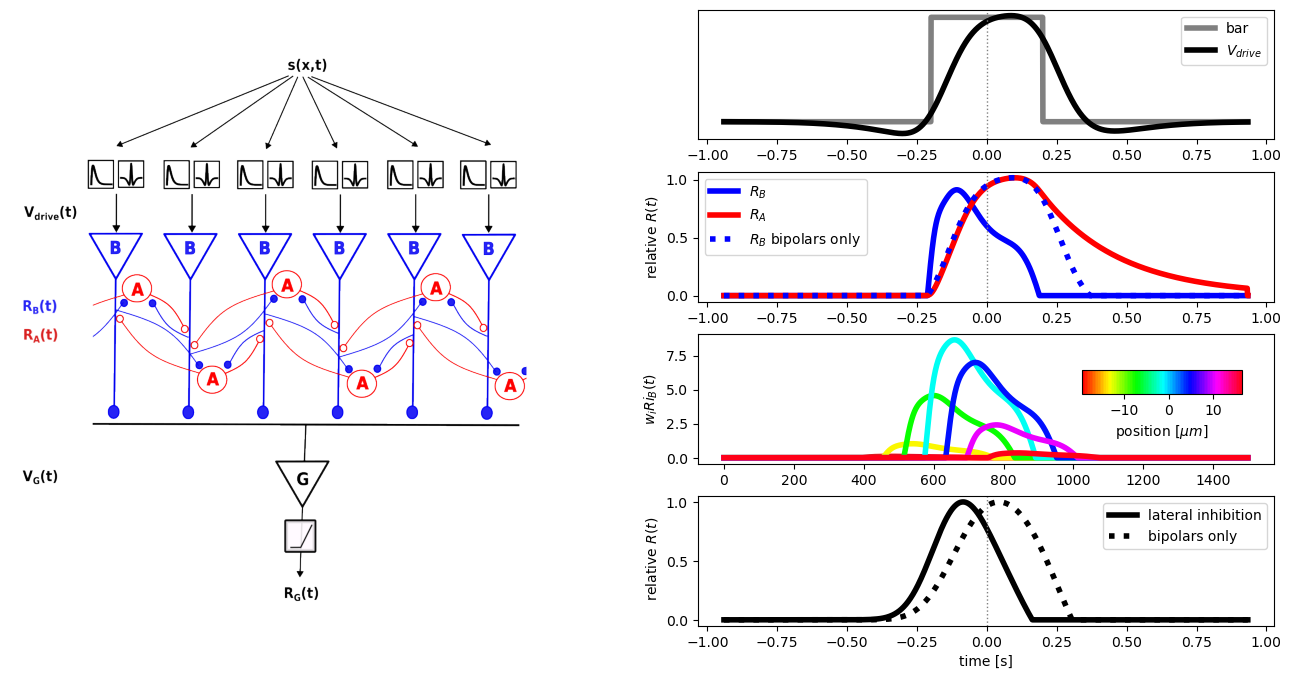

In [33]:
cbar = 'grey'
c1 = 'blue'
c2 = 'red'
speed_plot = -3

#initialize figure
nrows = 4
ncols = 4

fig = plt.figure(figsize=figsize)
fig.patch.set_facecolor('white')


gs = fig.add_gridspec(nrows,ncols)



fig.subplots_adjust(top=0.88,
bottom=0.11,
left=0.11,
right=0.9,
hspace=0.25,
wspace=0.48)



ax = fig.add_subplot(gs[:,:2], frameon = False)


ax.set_xticks([])
ax.set_yticks([])


ax.imshow(circuit_scheme,aspect = 'equal')

ax = fig.add_subplot(gs[0,2:])
time = data['times'][speed_plot]
barr = [bar(t,pos_cell, v = speeds[speed_plot]) for t in time]

xdata = time  - pos_cell/speeds[speed_plot]
ax.plot(xdata ,barr, linewidth = lw, color = cbar, label = 'bar')
ax.plot(xdata,data[net]['F'][speed_plot]/np.max(data[net]['F'][-1]), label = '$V_{drive}$', color = 'k', linewidth = lw)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
#ax.set_ylabel('$V(t)')
ax.legend()
ax.set_yticks([])


ax = fig.add_subplot(gs[1,2:])
RB =data[net]['RB'][speed_plot]
RA =data[net]['RA'][speed_plot]   

ax.plot(xdata,RB/np.max(data[net]['RB'][-1]), color = c1, linewidth = lw, label = '$R_{B}$')
#ax.plot(xdata,RB, color = c1, linewidth = lw)

ax.plot(xdata,RA/np.max(data[net]['RA'][-1]), color = c2, linewidth = lw, label = '$R_{A}$')
#ax.plot(xdata,RA, color = c2, linewidth = lw)

ax.plot(xdata,data[net_pool]['RB'][speed_plot]/np.max(data[net_pool]['RB'][-1]), label = '$R_{B}$ bipolars only', color = c1, linestyle = ':', linewidth = lw)
#ax.plot(xdata,data[net_pool]['RB'][speed_plot], label = f'RB without lateral connectivity', color = c1, linestyle = ':', linewidth = lw)

ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('relative $R(t)$')
ax.legend()


# add panel with all BC responses that the GC pools over
ax = fig.add_subplot(gs[2,2:])


# get BC cells that the GC pools from 
rf = DOG(paramsi['pos_rf_mid'],paramsi['pos_rf_mid'][cell],paramsi['std_GC'], paramsi['std_GC_s'], paramsi['w_GC'])
#rf = DOG(self.pos_rf_mid,self.pos_rf_GC_mid[i],self.std_GC,self.std_GC_surround,self.w)

BC_cells = []
BC_pos = []
BC_cells_weight = []

for p,val in enumerate(rf):
    if val >= 0.01:
        BC_cells.append(p)
        BC_pos.append((paramsi['pos_rf_mid'][p]-paramsi['pos_rf_mid'][cell])*100)
        BC_cells_weight.append(val)

#ax[0.scatter(BC_cells,rf[BC_cells])
print(BC_pos)
BC_cells= np.asarray(BC_cells)- cell
BC_cells = BC_cells.astype(int)
BC_cells_weight = np.asarray(BC_cells_weight)

BC_cells_short = BC_cells[0::12]
BC_pos_short = np.asarray(BC_pos[0::12])
BC_cells_weight_short = BC_cells_weight[0::12]
print(BC_cells_short)

cmap = plt.get_cmap('hsv', len(BC_cells_short))


for i,c in enumerate(BC_cells_short):

    r =  out['RB'][50 + c] *BC_cells_weight_short[i] 

    #ax.plot(r,linewidth = lw,  color = 'blue', alpha = (1-np.abs(c*0.01))-0.5)
    ax.plot(r,linewidth = lw,  color = cmap(i), label = f'{np.round(BC_pos_short[i])}')

#ax.legend()
cbar_ax = fig.add_axes([.78, .4, .1, .03])
cNorm = colors.Normalize(vmin =BC_pos_short.min(), vmax = BC_pos_short.max())
cmap = plt.get_cmap('hsv', 100)

scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
fig.colorbar(scalarMap,
             cax=cbar_ax, orientation='horizontal', label='position [$\mu m$]')


ax.set_ylabel('$w_{i} R{i}_{B}(t)$')


ax = fig.add_subplot(gs[3,2:])
RG_pool =data[net_pool]['RG'][speed_plot]
RG =data[net]['RG'][speed_plot]
ax.plot(time - pos_cell/speeds[speed_plot],RG/RG.max(), color = 'k', linewidth = lw, label = 'lateral inhibition')
ax.plot(time - pos_cell/speeds[speed_plot],RG_pool/RG_pool.max(), linestyle = ':', color = 'k', linewidth = lw, label = 'bipolars only')

ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.legend()
ax.set_ylabel(' relative $R(t)$')
ax.set_xlabel('time [s]')


fig.savefig('../svg/1B_FF_FB_net_mec.svg', format='svg')


# speed scaling

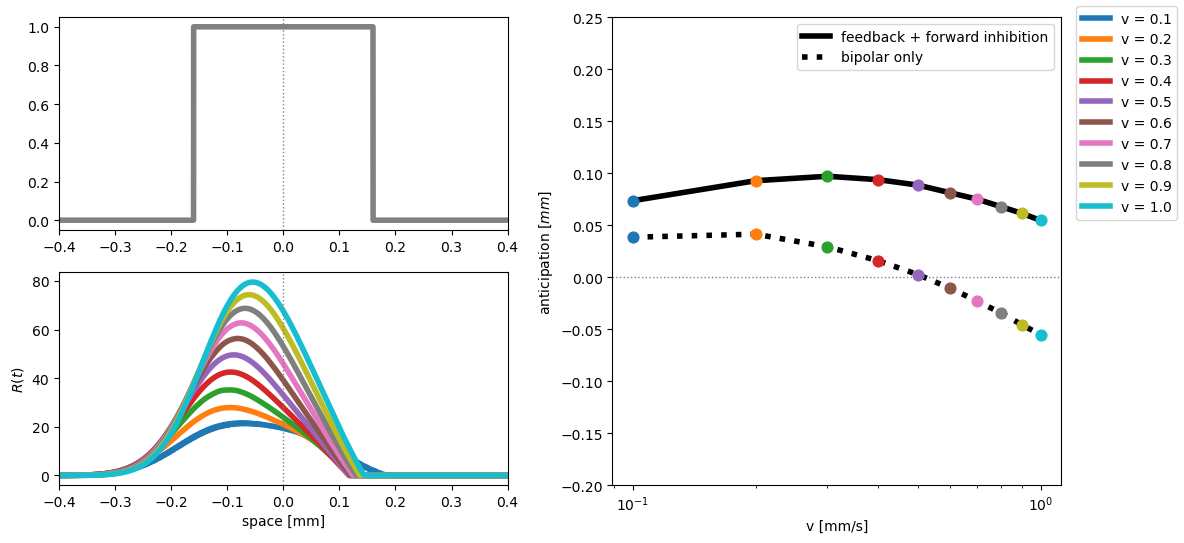

In [35]:
#initialize figure
nrows = 2
ncols = 4

fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')



fig.subplots_adjust(top=0.975,
bottom=0.195,
left=0.065,
right=0.9,
hspace=0.2,
wspace=0.61)



gs = fig.add_gridspec(nrows,ncols)


ax = fig.add_subplot(gs[0,0:2])
x = 0

ti = data['times'][x]
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
ax.plot(ti*speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


ax = fig.add_subplot(gs[1,0:2], sharex = ax)
for x,si in enumerate(speeds[:]):
    ti = data['times'][x]*si
    RG = data[net]['RG'][x]
    ax.plot(ti  - pos_cell, RG, label = f'v = {si}', linewidth = lw)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_xlabel('space [mm]')
ax.set_ylabel('$R(t)$')
ax.set_xlim(-0.4,0.4)
fig.legend()
ax = fig.add_subplot(gs[:,2:])

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['ants']['RG_bar'] * speeds
antis_pool = data[net_pool]['ants']['RG_bar'] * speeds


ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'feedback + forward inhibition')
ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = ':', label = 'bipolar only')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
    ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
ax.legend()


#col = p.get_facecolors()[idx].tolist()
ax.set_ylim(-.2,.25)
ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel('anticipation [$mm$]')


fig.savefig('../svg/2B_FF_low_FB_speedscaling.svg', format='svg')
